**Import needed libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import cpi
import miceforest as mf
from matplotlib.ticker import NullFormatter
from bs4 import BeautifulSoup
from scipy.stats import chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# uncomment this procedure call if the cpi library returns a warning about its data being out of date
#cpi.update()

**Use '%matplotlib inline', to display and store the plots within Jupyter Notebook**

In [4]:
%matplotlib inline

**Set the theme to 'ggplot'**

In [5]:
plt.style.use("ggplot")

**Suppress Scientific Notation**

In [6]:
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

**Load the movies dataset using 'read_csv' and create a DataFrame**

In [7]:
df_movies = pd.read_csv("movies.csv")

**Display all rows and columns of the DataFrame**

In [8]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

**Check the DataFrame**

In [9]:
df_movies.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.40,927000.00,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.00,46998772.00,Warner Bros.,146.00
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.80,65000.00,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.00,58853106.00,Columbia Pictures,104.00
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.70,1200000.00,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.00,538375067.00,Lucasfilm,124.00
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.70,221000.00,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.00,83453539.00,Paramount Pictures,88.00
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.30,108000.00,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.00,39846344.00,Orion Pictures,98.00


**Check for duplicate records**

In [10]:
df_movies[df_movies.duplicated()]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime


**Use 'info()' for more information on the DataFrame**

In [11]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


**Find the number of NaN values in the DataFrame per column**

In [12]:
for col in df_movies:
    missing = df_movies[col].isnull().sum()
    print(f"{col} {missing}")

name 0
rating 77
genre 0
year 0
released 2
score 3
votes 3
director 0
writer 3
star 1
country 3
budget 2171
gross 189
company 17
runtime 4


**Find the percent of NaN values in the DataFrame per column**

In [13]:
for col in df_movies:
    pct_missing = df_movies[col].isnull().mean().round(5)
    print(f"{col} - {pct_missing}%")

name - 0.0%
rating - 0.01004%
genre - 0.0%
year - 0.0%
released - 0.00026%
score - 0.00039%
votes - 0.00039%
director - 0.0%
writer - 0.00039%
star - 0.00013%
country - 0.00039%
budget - 0.28312%
gross - 0.02465%
company - 0.00222%
runtime - 0.00052%


*Most missing values are in columns 'gross' (189 missing values, 0.02%) and 'budget' (2171 missing values, 0.28%)*

**Examine further the 'year' column**

In [14]:
df_movies["year"].value_counts()

year
2000    200
2009    200
2002    200
2003    200
2004    200
2005    200
2006    200
2007    200
2008    200
2010    200
2019    200
2011    200
2012    200
2013    200
2014    200
2015    200
2016    200
2017    200
2001    200
1999    200
1990    200
1991    200
1985    200
1986    200
1987    200
1988    200
1989    200
1998    200
2018    200
1992    200
1993    200
1994    200
1995    200
1996    200
1997    200
1984    168
1983    144
1982    126
1981    113
1980     92
2020     25
Name: count, dtype: int64

*The database contains exactly 200 movies per year (with the exception of movies produced from 1980 to 1984 and 2020)*

*For this reason the 'year' and 'released' columns will be used only for inflation adjustment on monetary values*

**Delete the rows that contain missing values in columns with categorical data\
(rating, released, writer, star etc.)**

In [15]:
drop_nan_columns = df_movies.loc(axis=1)["rating", "released", "writer", "star", "country", "company", "score", "votes"].columns
df_movies = df_movies.dropna(subset=drop_nan_columns)

**Check the missing values again**

In [16]:
for col in df_movies:
    missing = df_movies[col].isnull().sum()
    print(f"{col} {missing}")

name 0
rating 0
genre 0
year 0
released 0
score 0
votes 0
director 0
writer 0
star 0
country 0
budget 2101
gross 162
company 0
runtime 1


*The missing values in columns 'gross' are 162 and in column 'budget' are 2101*

**Assume the missing data are MCAR/MAR and use multiple imputation to generate replacement values\***

**Since we don't have access to the data source, we can't detect the type and mechanism of the missing data (MCAR/MAR/MNAR)\
So imputing the missing values, will probably introduce bias into the dataset\
The following imputing method (MI), assumes that the missing data are at least MAR, and is performed mainly for demonstration purposes*

**Create a copy of the DataFrame that contains the three columns with the missing data**

In [17]:
df_movies_imput_col = df_movies[["budget", "gross", "runtime"]].copy(deep=True)

**Reset the Index of the DataFrame**

In [18]:
df_movies_imput_col = df_movies_imput_col.reset_index(drop=True)

**Create kernel**

In [19]:
# Set the random state equal to any number, to ensure that the splits generated are reproducible.
kds = mf.ImputationKernel(
    df_movies_imput_col,
    num_datasets=5,
    save_all_iterations_data=True,
    mean_match_candidates=5,
    mean_match_strategy="sharp",  # or try "shap"
    copy_data=True
    #random_state=42
)

**Run the algorithm for 5 iterations, while injecting variability**

In [20]:
kds.mice(iterations=5)

**Confirm that kds.mice() run and saved five iterations**

In [21]:
kds.iteration_count()

5

*Change the parameters below to view a specific iteration*

In [22]:
kds.complete_data(dataset=4, iteration=3).head()

,budget,gross,runtime
0,19000000.00,46998772.00,146.00
1,4500000.00,58853106.00,104.00
2,18000000.00,538375067.00,124.00
3,3500000.00,83453539.00,88.00
4,6000000.00,39846344.00,98.00


**Combine the iterations using 'concat' and 'median()' into the final imputated dataset**

In [23]:
df_movies_imput_col_final = pd.concat([kds.complete_data(i) for i in range(5)]).groupby(level=0).median()

**Ensure we are storing all the imputed data**

In [24]:
df_movies_imput_col_final = kds.complete_data(dataset=0, iteration=4).reset_index(drop=True)

In [25]:
df_movies_imput_col_final.head()

,budget,gross,runtime
0,19000000.00,46998772.00,146.00
1,4500000.00,58853106.00,104.00
2,18000000.00,538375067.00,124.00
3,3500000.00,83453539.00,88.00
4,6000000.00,39846344.00,98.00


In [26]:
df_movies_imput_col_final.isnull().sum()

budget     0
gross      0
runtime    0
dtype: int64

**Replace the columns with missing values**

In [27]:
df_movies[["budget", "gross", "runtime"]] = df_movies_imput_col_final[["budget", "gross", "runtime"]].values

**Check the df_movies DataFrame for missing values**

In [28]:
df_movies.isnull().sum()

name        0
rating      0
genre       0
year        0
released    0
score       0
votes       0
director    0
writer      0
star        0
country     0
budget      0
gross       0
company     0
runtime     0
dtype: int64

**Convert the datatype for columns 'budget' and 'gross' from float to integer using 'astype()'**

In [29]:
df_movies["budget"] = df_movies["budget"].astype("int64")
df_movies["gross"] = df_movies["gross"].astype("int64")

**Create a new column using the 'released' column, in order to find the correct year that each movie was released**

In [30]:
# Used 'str[-5:-1]' because some of the release dates were missing the day and month of release resulting in NaN values
df_movies["release_year"] = df_movies.released.str.split("(").str[0].str[-5:-1]

**Convert the datatype for the 'release_year' column to int using 'astype()'**

In [31]:
df_movies["release_year"] = df_movies["release_year"].astype("int64")

**Adjust for inflation**

*The 'budget' and 'gross' columns contain monetary values that are not adjusted for inflation*

*Adjusting for ticket price inflation is not an exact science and should be viewed only as an indicator\
of what the earnings of a movie might have been if released in a different year, assuming the same number of ticket sales*

*The 'gross' column of the DataFrame refers to the worldwide gross revenue for each movie, including domestic gross (in USD $)*

**Check the percent of movies produced per country**

In [32]:
df_movies["country"].value_counts(normalize=True) * 100

country
United States                    71.91
United Kingdom                   10.67
France                            3.50
Canada                            2.47
Germany                           1.50
Australia                         1.20
Japan                             0.99
India                             0.81
Italy                             0.77
Spain                             0.62
Hong Kong                         0.57
Ireland                           0.57
China                             0.46
Denmark                           0.41
South Korea                       0.41
New Zealand                       0.33
Sweden                            0.32
Mexico                            0.28
Norway                            0.16
Netherlands                       0.16
Iran                              0.13
Switzerland                       0.13
West Germany                      0.12
Russia                            0.11
Belgium                           0.11
Czech Republic   

*The vast majority of movies are produced in USA*

*For simplicity reasons, we will use the U.S. as the basis for the inflation adjustments*

**Adjust the 'budget' column for inflation**

*In order to adjust the 'budget' column, we use the annual core consumer price inflation\
(Food and energy are exempt from this metric, since those prices can be too volatile or fluctuate wildly)*

**Create a dictionary of inflation multipliers**

In [33]:
unique_years = df_movies["release_year"].dropna().unique()

In [34]:
inflation_factors = {year: cpi.inflate(1.0, year, items="All items less food and energy") for year in unique_years}

**Map the multiplier to each row**

In [35]:
df_movies["inflation_factor"] = df_movies["release_year"].map(inflation_factors)

**Adjust the budget**

In [36]:
df_movies["infl_adj_budget"] = df_movies["budget"] * df_movies["inflation_factor"]

*In order to adjust the 'gross' column, we would have to use the CPI called:\
'Consumer Price Index for All Urban Consumers: Admission to Movies, Theaters, and Concerts'*

*Unfortunately the starting date for that CPI is 1997, so we cannot use the cpi package to calculate the adjusted gross earnings for movies that were released prior to that year*

*Instead we will use the annual average U.S. ticket prices provided by the National Assosiation of Theatre Owners (NATO)\
in order to calculate the inflation for ticket prices from 1980 and onwards*

*We should also note here that the figures we have from 1989 to 2022, are the outcome of NATO's surveys and data before 1989 are based on the CPI-W index*

*Before scraping the website we make sure that we are allowed to\
Add '/robots.txt' in the website's address (https://www.natoonline.org/robots.txt)*

*We get this message:\
\
Sitemap: https://www.natoonline.org/sitemap.xml \
Sitemap: https://www.natoonline.org/news-sitemap.xml \
User-agent: * \
Disallow: /wp-admin/ \
Allow: /wp-admin/admin-ajax.php*

*Scraping the website is allowed, with the exception of the 'wp-admin' path*

*The page that contains the necessary data:\
https://www.natoonline.org/data/ticket-price/*

In [37]:
# Save the url
url = "https://www.natoonline.org"

# Get the data using 'get'
page = requests.get(url)

# Check if the server responds properly (200)
print(page)

<Response [200]>


In [31]:
# Store the HTML code 
soup = BeautifulSoup(page.text, "html")

# Uncomment the next line to display the HTML code
#soup

**Find the headers of the table**

In [32]:
soup.find_all("th")

[<th class="column-1">Year</th>, <th class="column-2">Price</th>]

In [33]:
headers = soup.find_all("th")

**Clean and store the scraped headers**

In [34]:
column_header = [header.text.strip() for header in headers]

**Create the DataFrame that will store the scraped data**

In [35]:
df_movie_tickets_over_time = pd.DataFrame(columns=column_header)

df_movie_tickets_over_time

,Year,Price


**Continue scraping the rest of the DataFrame info**

In [36]:
column_data = soup.find_all("tr")[1: -1]

In [37]:
# Create a list to store the data
string_row_data = [data.text.strip() for data in column_data]

In [38]:
# Use 'split()' to create the data to be added on the 'Year' and 'Price' columns
list_row_data = [row_data.split("$") for row_data in string_row_data]

**Pass the data into the columns**

In [39]:
for row in list_row_data:
    length = len(df_movie_tickets_over_time)
    df_movie_tickets_over_time.loc[length] = row

**Check the Dataframe**

In [40]:
df_movie_tickets_over_time

,Year,Price
0,2022,10.53
1,2021,10.17
2,2020,9.18
3,2019,9.16
4,2018,9.16
5,2017,8.97
6,2016,8.65
7,2015,8.43
8,2014,8.17
9,2013,8.13


**Use 'info()' for more information on the DataFrame**

In [41]:
df_movie_tickets_over_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55 entries, 0 to 54
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    55 non-null     object
 1   Price   55 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


**Remove the '\*' character from the 1989 cell in the 'Year' column**

In [42]:
df_movie_tickets_over_time["Year"] = df_movie_tickets_over_time["Year"].str.replace("*", "")

**Convert the datatype of the 'Year' column to int and the datatype of the 'Price' column to float using 'astype()'**

In [43]:
df_movie_tickets_over_time = df_movie_tickets_over_time.astype({"Year": "int64", "Price": "float64"})

**Drop the rows that contain data prior to 1980 and create a copy of the new DataFrame**

In [44]:
df_movie_tickets_over_time_2 = df_movie_tickets_over_time[df_movie_tickets_over_time["Year"] >= 1980].copy(deep=True)

**Rearrange the Dataframe and use 'pct_change' to find the percent of change in average ticket prices from year to year**

In [45]:
df_movie_tickets_over_time_2.sort_values(by="Year", inplace=True, ignore_index=True)

df_movie_tickets_over_time_2["ticket_pct_change"] = df_movie_tickets_over_time_2["Price"].pct_change() * 100

**Check the DataFrame**

In [46]:
df_movie_tickets_over_time_2

,Year,Price,ticket_pct_change
0,1980,2.69,NaN
1,1981,2.78,3.35
2,1982,2.94,5.76
3,1983,3.15,7.14
4,1984,3.36,6.67
5,1985,3.55,5.65
6,1986,3.71,4.51
7,1987,3.91,5.39
8,1988,4.11,5.12
9,1989,3.99,-2.92


**Set the 1980 percent to 0 (since it's the starting point of the DataFrame)**

In [47]:
df_movie_tickets_over_time_2["ticket_pct_change"] = df_movie_tickets_over_time_2["ticket_pct_change"].fillna(0)

*Before continuing with the inflation adjustment on the 'gross' column, we need to mention a few important details about movie earnings\
Popular movies tend to be re-released to theaters from time to time, creating discrepancies in the method used to estimate the effects of inflation\
(since we cannot know exactly when newer ticket earnings got aggregated)\
For this reason, we assume that the gross earnings of each movie in the dataset, were accumulated as a whole, during the year of each movie's release*

**Calculate the average of the ticket price changes**

In [48]:
avg_pct_change_ticket_prices = df_movie_tickets_over_time_2["ticket_pct_change"].mean().round(2)
print(f"Ticket prices from 1980 to 2022 have been increasing by an average of {avg_pct_change_ticket_prices}% per year.")

Ticket prices from 1980 to 2022 have been increasing by an average of 3.26% per year.


**Use exponential powers to find the average inflation adjustment for each year**

*The base of the exponential factor is 1.0326 (or the assumed inflation rate of .0326 plus 1)*

*The number of times this base is multiplied by itself is the power,\
so we need to calculate the time difference between the date each movie was released and 2022 in years*

In [49]:
df_movie_tickets_over_time_2["annual_ticket_infl_adj"] = (1.0326 ** (2022 - df_movie_tickets_over_time_2["Year"]))

In [50]:
df_movie_tickets_over_time_2

,Year,Price,ticket_pct_change,annual_ticket_infl_adj
0,1980,2.69,0.00,3.85
1,1981,2.78,3.35,3.73
2,1982,2.94,5.76,3.61
3,1983,3.15,7.14,3.49
4,1984,3.36,6.67,3.38
5,1985,3.55,5.65,3.28
6,1986,3.71,4.51,3.17
7,1987,3.91,5.39,3.07
8,1988,4.11,5.12,2.98
9,1989,3.99,-2.92,2.88


**Create a new DataFrame that adds the new column to the 'df_movies' Dataframe using 'merge'**

*Rename the 'Year' column to 'release_year' to merge the two DataFrames*

In [51]:
df_movie_tickets_over_time_2.rename(columns = {"Year": "release_year"}, inplace = True)

In [52]:
df_movies_merged = df_movies.merge(df_movie_tickets_over_time_2[["release_year", "annual_ticket_infl_adj"]], on="release_year", how="left")

**Adjust the 'gross' column for inflation**

In [53]:
df_movies_merged["infl_adj_gross"] = df_movies_merged["gross"] * df_movies_merged["annual_ticket_infl_adj"]

**Convert the datatype of columns 'infl_adj_budget' and 'infl_adj_gross' to int using 'astype()'**

In [54]:
df_movies_merged = df_movies_merged.astype({"infl_adj_budget": "int64", "infl_adj_gross": "int64"})

**Check the columns before and after inflation adjustmen**

In [56]:
df_movies_merged.loc[:, ["name", "budget", "infl_adj_budget", "gross", "infl_adj_gross"]].round(4).sort_values(by="infl_adj_gross", inplace=False, ascending=False).head(10)

,name,budget,infl_adj_budget,gross,infl_adj_gross
3009,Titanic,200000000,363871386,2201647264,4909652538
5390,Avatar,237000000,333369658,2847246203,4320585379
7381,Avengers: Endgame,356000000,417093647,2797501328,3080113097
206,E.T. the Extra-Terrestrial,10500000,33799587,792910554,2860941825
2414,The Lion King,45000000,88671853,1083720877,2660828108
2214,Jurassic Park,63000000,127647851,1033928303,2621331368
6605,Star Wars: Episode VII - The Force Awakens,245000000,311885575,2069521700,2590567003
7181,Avengers: Infinity War,321000000,384331337,2048359754,2328813538
3409,Star Wars: Episode I - The Phantom Menace,115000000,200360536,1027082707,2148049046
4195,The Lord of the Rings: The Return of the King,94000000,150040445,1146030912,2108174838


**Find the profit/loss of each movies**

*Use columns 'infl_adj_budget' and 'infl_adj_gross' to find if a movie was profitable or not\
Since we don't have access to the net earnings of each movie in this dataset,\
we will use the new column as an approximate indicator*

In [57]:
df_movies_merged["profit_loss"] = df_movies_merged["infl_adj_gross"] - df_movies_merged["infl_adj_budget"]

**Test for Multicollinearity**

*To detect multicollinearity in data we use the Variance Inflation Factor (VIF) metric*

**Create a dataframe that contains all the independent variables**

*The dependent variable in the dataset is the gross earnings of each movie, so we omit the "gross" column*

In [58]:
# Columns to check using VIF for multicollinearity
indep_var = df_movies_merged[["score", "votes", "infl_adj_budget", "runtime", "release_year"]]

In [59]:
vif = pd.DataFrame()

In [60]:
vif["variables"] = indep_var.columns

In [61]:
vif["vif_factor"] = [variance_inflation_factor(indep_var.values, i) for i in range(indep_var.shape[1])]
vif

,variables,vif_factor
0,score,62.95
1,votes,1.97
2,infl_adj_budget,2.57
3,runtime,46.29
4,release_year,65.98


*VIF quantifies the strength of correlation:\
1 indicate no correlation,\
between 1 and 5 indicate a moderate correlation,\
values greater than 5 represent a critical level of correlation in variables.*

*The very high VIF values for 'score', 'runtime' and 'release_year' indicate a strong correlation in this dataset*

**Create a copy of the DataFrame without the redandant variables 'release_year' and 'score' to remedy multicollinearity**

*When choosing between the 'score' and 'runtime' columns that appear to be correlated, we opt to delete 'score',\
since that column only applies to IMDB users only, so it's of lesser importance in the analysis*

*Also drop the no longer needed columns 'year' and 'release'*

In [62]:
df_movies_2 = df_movies_merged.drop(["score", "release_year", "year", "released"], axis=1)

**Test for Multicollinearity again**

In [63]:
indep_var = df_movies_2[["votes", "budget", "runtime"]]

In [64]:
vif = pd.DataFrame()

In [65]:
vif["variables"] = indep_var.columns

In [66]:
vif["vif_factor"] = [variance_inflation_factor(indep_var.values, i) for i in range(indep_var.shape[1])]
vif

,variables,vif_factor
0,votes,1.69
1,budget,2.16
2,runtime,1.81


*The VIF values dropped below 5, after removing the highly correlated variables*

**Begin EDA**

**Sort the DataFrame in a descending way, using the 'profit_loss' column, in order to find the highest-grossing films**

In [67]:
df_movies_2.sort_values(by=["gross"], inplace=False, ascending=False).head(5)

,name,rating,genre,votes,director,writer,star,country,budget,gross,company,runtime,infl_adj_budget,annual_ticket_infl_adj,infl_adj_gross,profit_loss
5390,Avatar,PG-13,Action,1100000.00,James Cameron,James Cameron,Sam Worthington,United States,237000000,2847246203,Twentieth Century Fox,162.00,333369658,1.52,4320585379,3987215721
7381,Avengers: Endgame,PG-13,Action,903000.00,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,356000000,2797501328,Marvel Studios,181.00,417093647,1.10,3080113097,2663019450
3009,Titanic,PG-13,Drama,1100000.00,James Cameron,James Cameron,Leonardo DiCaprio,United States,200000000,2201647264,Twentieth Century Fox,194.00,363871386,2.23,4909652538,4545781152
6605,Star Wars: Episode VII - The Force Awakens,PG-13,Action,876000.00,J.J. Abrams,Lawrence Kasdan,Daisy Ridley,United States,245000000,2069521700,Lucasfilm,138.00,311885575,1.25,2590567003,2278681428
7181,Avengers: Infinity War,PG-13,Action,897000.00,Anthony Russo,Christopher Markus,Robert Downey Jr.,United States,321000000,2048359754,Marvel Studios,149.00,384331337,1.14,2328813538,1944482201


**Create a histogram**

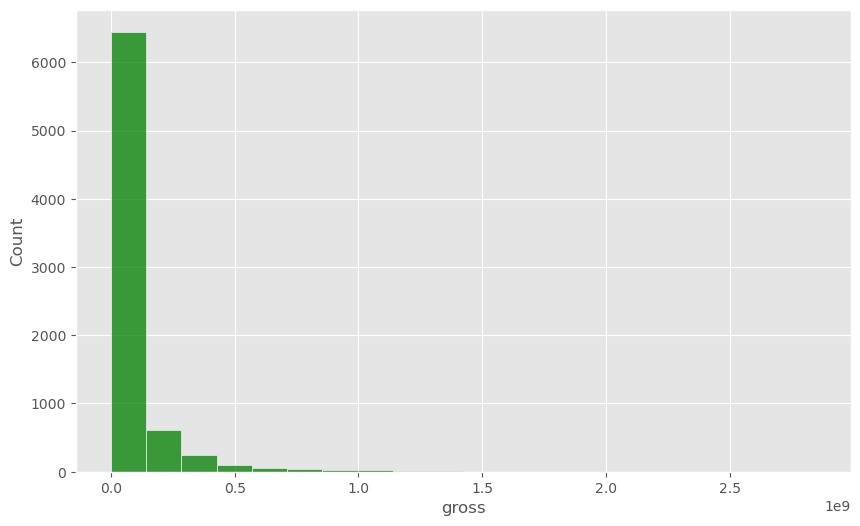

In [68]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.histplot(data=df_movies_2, x=df_movies_2["gross"], bins=20, color='green')

**Create a scatterplot with a regression line, using the adjusted for inflation 'budget' and 'gross' columns**

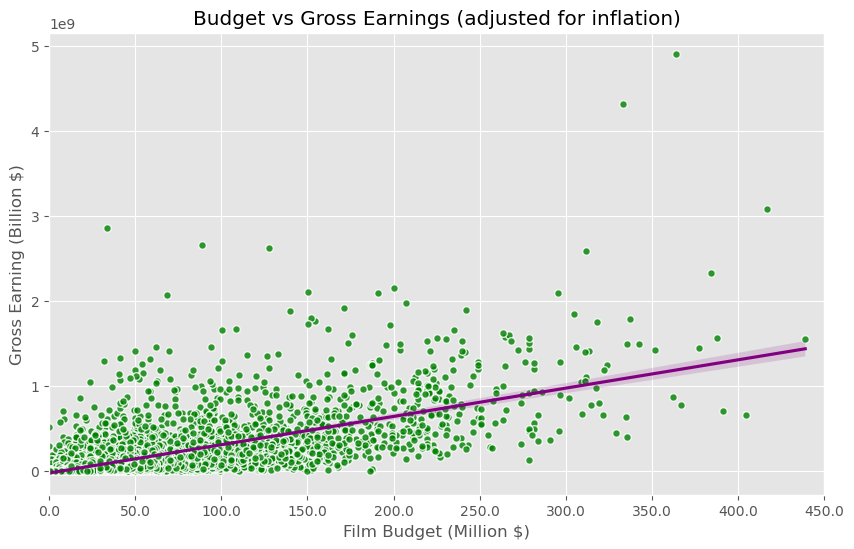

In [69]:
# Create a function in order to suppress the scientific notation in the x axis
def formatter(x, pos):
    return str(round(x / 1e6, 1))

# Create the regplot
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.regplot(data=df_movies_2, x="infl_adj_budget", y="infl_adj_gross", color='green', 
                 line_kws={"color": "Purple"}, scatter_kws={"s": 30, "edgecolors": "white"})

# Set the x-axis range
ax.set_xlim(xmin=-0, xmax=450000000)

# Set the major and minor ticks for the x axis
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_formatter(NullFormatter())

# Add title and axis labels
ax.set_title("Budget vs Gross Earnings (adjusted for inflation)")
ax.set_ylabel("Gross Earning (Billion $)")
ax.set_xlabel("Film Budget (Million $)");

**Create a correlation matrix from the DataFrame**

In [70]:
df_movies_2.corr(numeric_only=True)

,votes,budget,gross,runtime,infl_adj_budget,annual_ticket_infl_adj,infl_adj_gross,profit_loss
votes,1.00,0.47,0.63,0.31,0.45,-0.23,0.65,0.64
budget,0.47,1.00,0.76,0.32,0.97,-0.30,0.69,0.56
gross,0.63,0.76,1.00,0.25,0.70,-0.25,0.95,0.92
runtime,0.31,0.32,0.25,1.00,0.34,-0.12,0.25,0.21
infl_adj_budget,0.45,0.97,0.70,0.34,1.00,-0.14,0.68,0.55
annual_ticket_infl_adj,-0.23,-0.30,-0.25,-0.12,-0.14,1.00,-0.13,-0.12
infl_adj_gross,0.65,0.69,0.95,0.25,0.68,-0.13,1.00,0.99
profit_loss,0.64,0.56,0.92,0.21,0.55,-0.12,0.99,1.00


**Create a DataFrame heatmap**

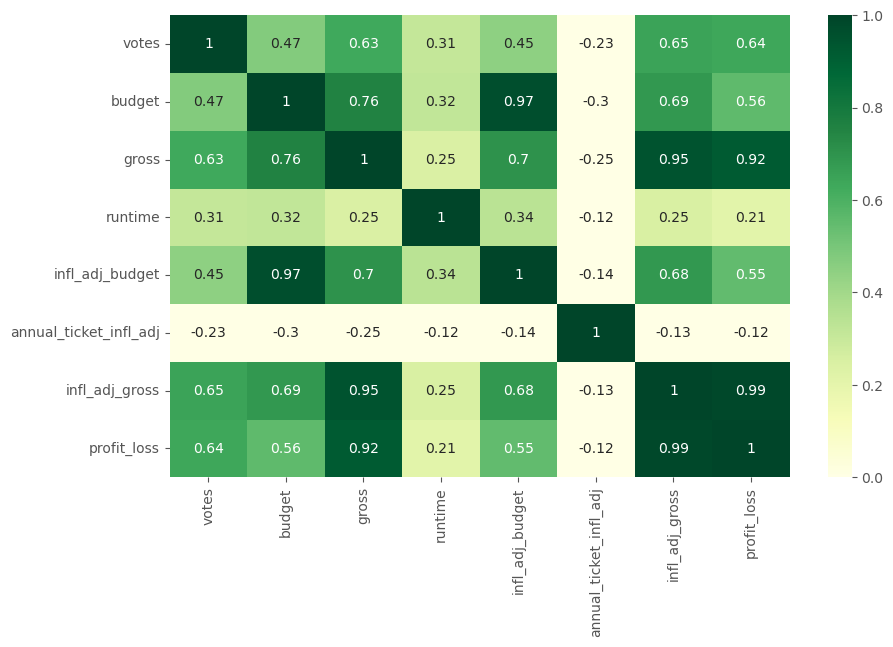

In [71]:
# Create the heatmap
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(data=df_movies_2.corr(numeric_only=True),vmin=0, vmax=1, cmap="YlGn", annot=True)

*We notice that the correlation coefficient for the columns 'budget' and 'gross'\
is equal to 0.76 (0.68 when adjusting for inflation), which indicates a strong positive linear relationship*

**Find the number of movies per genre**

In [72]:
df_movies_2["genre"].value_counts()

genre
Comedy       2230
Action       1696
Drama        1476
Crime         544
Biography     439
Adventure     426
Animation     334
Horror        318
Fantasy        43
Mystery        20
Thriller       16
Family         10
Sci-Fi          9
Romance         8
Western         3
Music           1
Sport           1
Musical         1
Name: count, dtype: int64

**Create a pie chart that depicts the percentage for the Top5 genres**

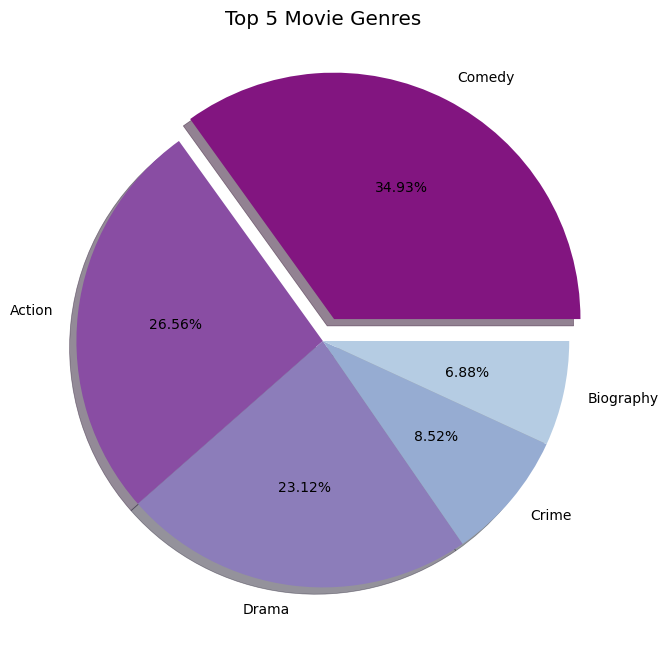

In [73]:
# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.pie(x=df_movies_2["genre"].value_counts()[:5], explode=[0.1, 0, 0, 0, 0],
             labels=df_movies_merged["genre"].value_counts()[:5].index, colors=sns.color_palette("BuPu_r"), autopct="%3.2f%%", shadow=True)

# Add title
plt.title("Top 5 Movie Genres");

*Comedies, Action and Drama movies have the highest popularity among genres*

**Find the profit/loss per movie genre**

In [74]:
df_movies_2.groupby("genre")["profit_loss"].sum().sort_values(ascending=False)

genre
Action       265150826918
Comedy       116449457988
Animation     88910828976
Drama         59705546284
Adventure     51278883995
Crime         21306176424
Biography     18978084566
Horror        18110470585
Family         4096008736
Mystery        2781165049
Fantasy        2188607937
Thriller        369870968
Sci-Fi          105166016
Romance          92563265
Western          14015651
Musical         -15132922
Sport           -15227075
Music           -54326194
Name: profit_loss, dtype: int64

**Create a barplot that depicts Top 5 most profitable movie genres**

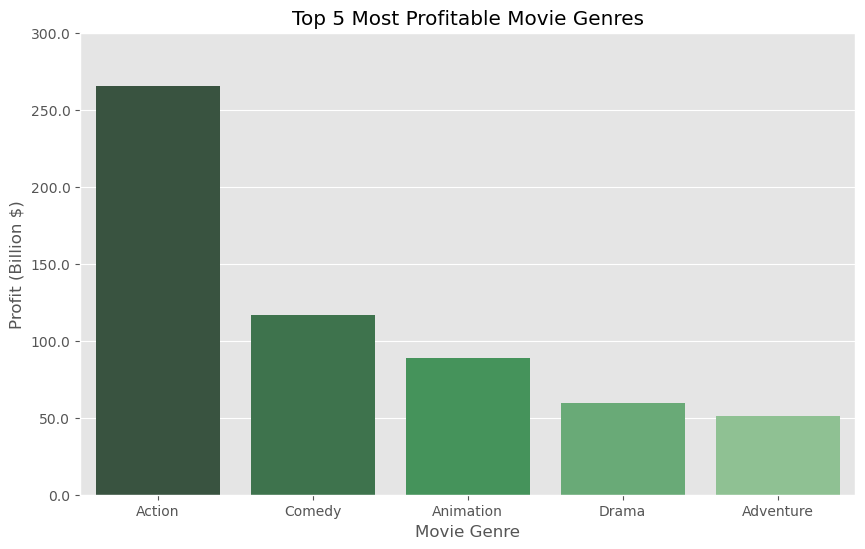

In [75]:
# Create a function in order to suppress the scientific notation in the y axis
def formatter_2(y, pos):
    return str(round(y / 1e9, 1))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=df_movies_2.groupby("genre")["profit_loss"].sum().sort_values(ascending=False).nlargest(5).index,
               y=df_movies_2.groupby("genre")["profit_loss"].sum().sort_values(ascending=False).nlargest(5).values, palette="Greens_r_d")

# Set the y-axis range
ax.set_ylim(ymin=-0, ymax=300000000000)

# Set the major and minor ticks for the y axis
ax.yaxis.set_major_formatter(formatter_2)
ax.yaxis.set_minor_formatter(NullFormatter())

# Add title and axis labels
ax.set_title("Top 5 Most Profitable Movie Genres")
ax.set_ylabel("Profit (Billion $)")
ax.set_xlabel("Movie Genre");

*Action, Animation and Comedy films are the Top 3 most profitable genres, followed by Drama and Adventure films*

**Create a barplot that depicts the 5 least profitable movie genres**

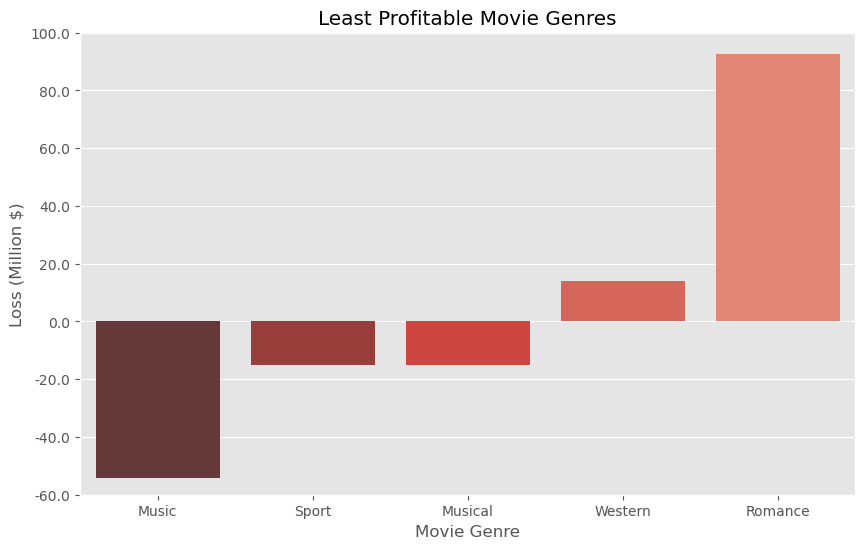

In [76]:
# Create a function in order to suppress the scientific notation in the y axis
def formatter_3(y, pos):
    return str(round(y / 1e6, 1))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=df_movies_2.groupby("genre")["profit_loss"].sum().sort_values(ascending=False).nsmallest(5).index,
               y=df_movies_2.groupby("genre")["profit_loss"].sum().sort_values(ascending=False).nsmallest(5).values, palette="Reds_r_d")

# Set the y-axis range
ax.set_ylim(ymin=-60000000, ymax=100000000)

# Set the major and minor ticks for the y axis
ax.yaxis.set_major_formatter(formatter_3)
ax.yaxis.set_minor_formatter(NullFormatter())

# Add title and axis labels
ax.set_title("Least Profitable Movie Genres")
ax.set_ylabel("Loss (Million $)")
ax.set_xlabel("Movie Genre");

*Music, Musical and Sports films are the least profitable film genres*

**Find the number of movies per rating**

In [77]:
df_movies_2["rating"].value_counts()

rating
R            3689
PG-13        2111
PG           1249
Not Rated     282
G             153
Unrated        50
NC-17          23
TV-MA           9
TV-PG           4
X               3
Approved        1
TV-14           1
Name: count, dtype: int64

**Create a pie chart that depicts the distribution of the five most common movie ratings**

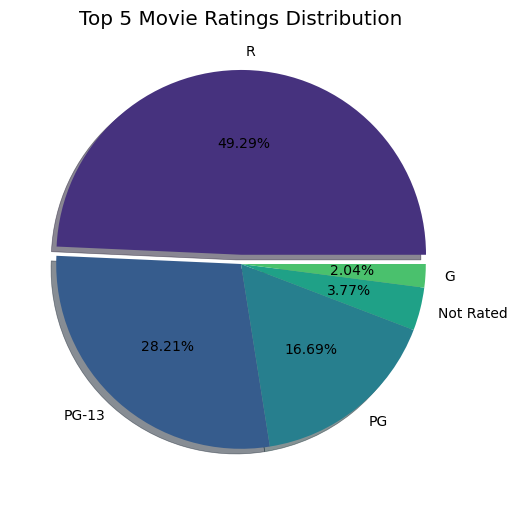

In [78]:
# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 6))
ax = plt.pie(x=df_movies_2["rating"].value_counts()[:5], explode=[0.05, 0, 0, 0, 0],
             labels=df_movies_2["rating"].value_counts()[:5].index, colors=sns.color_palette("viridis"), autopct="%3.2f%%", shadow=True)

# Add title
plt.title("Top 5 Movie Ratings Distribution");

*Most movies are rated as 'R', 'PG-13', or 'PG'*

**Find the movie studio companies with the most produced films**

In [79]:
df_movies_2["company"].value_counts()[:10]

company
Universal Pictures           377
Warner Bros.                 333
Columbia Pictures            332
Paramount Pictures           320
Twentieth Century Fox        240
New Line Cinema              173
Touchstone Pictures          132
Metro-Goldwyn-Mayer (MGM)    125
Walt Disney Pictures         123
TriStar Pictures              94
Name: count, dtype: int64

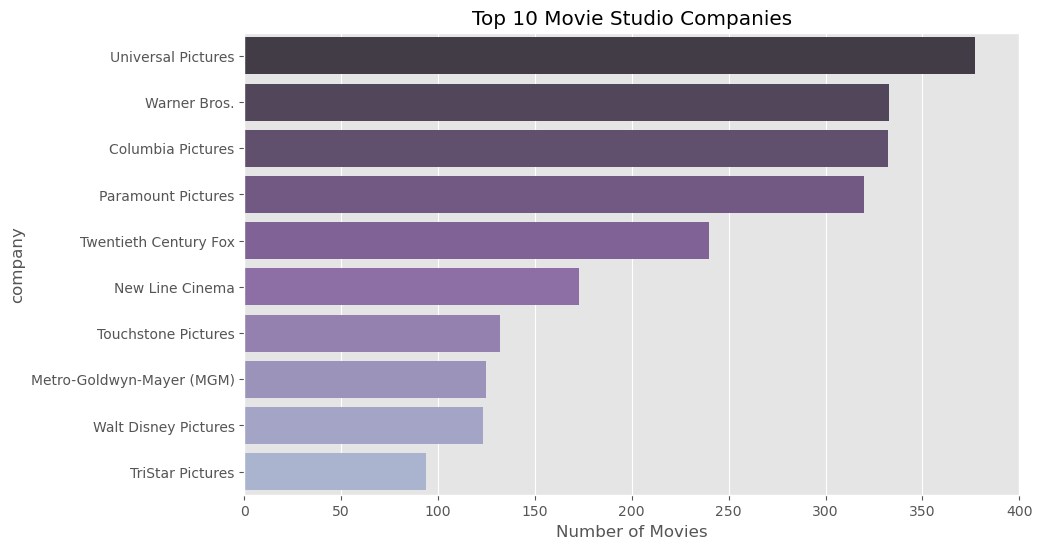

In [80]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=df_movies_2["company"].value_counts()[:10].values, 
                 y=df_movies_2["company"].value_counts()[:10].index, palette="BuPu_r_d")

# Set the x axis range
ax.set_xlim(xmin=0, xmax=400)

# Add title and axis labels
ax.set_title("Top 10 Movie Studio Companies")
ax.set_xlabel('Number of Movies');

*Universal, Warner and Columbia are the Top 3 movie production companies*

**Find the highest-grossing film directors**

In [83]:
df_movies_2.groupby("director")["infl_adj_gross"].sum().sort_values(ascending=False)[:10]

director
Steven Spielberg    21325995229
James Cameron       12509158343
Peter Jackson       10777573903
Michael Bay         10323845012
Robert Zemeckis      9896449250
Chris Columbus       8800169562
Ron Howard           8469680043
David Yates          8452351720
Tim Burton           8104271039
Anthony Russo        7948757156
Name: infl_adj_gross, dtype: int64

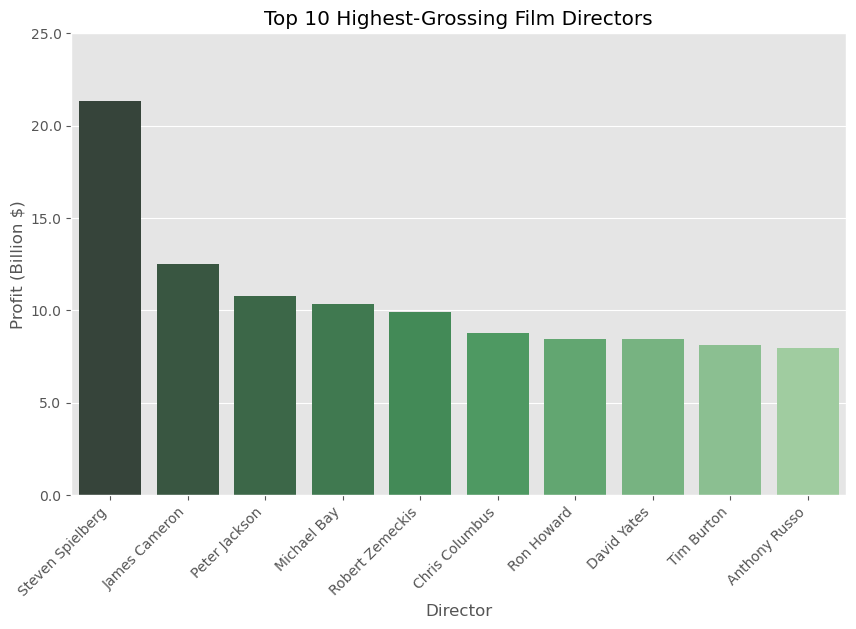

In [84]:
# Create a function in order to suppress the scientific notation in the y axis
def formatter_5(y, pos):
    return str(round(y / 1e9, 1))

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=df_movies_2.groupby("director")["infl_adj_gross"].sum().sort_values(ascending=False)[:10].index,
               y=df_movies_2.groupby("director")["infl_adj_gross"].sum().sort_values(ascending=False)[:10].values, palette="Greens_r_d")

# Set the y-axis range
ax.set_ylim(ymin=-0, ymax=25000000000)

# Set the major and minor ticks for the y axis
ax.yaxis.set_major_formatter(formatter_5)
ax.yaxis.set_minor_formatter(NullFormatter())

# Add title and axis labels
ax.set_title("Top 10 Highest-Grossing Film Directors")
ax.set_ylabel("Profit (Billion $)")
ax.set_xlabel("Director")
ax.set_xticklabels(labels=df_movies_merged.groupby("director")["infl_adj_gross"].sum().sort_values(ascending=False)[:10].index,
                   rotation=45, ha="right");